# Q1: Converting the script to a Prefect flow

```python
@flow(task_runner=SequentialTaskRunner())
def main(train_path: str = 'data/fhv_tripdata_2021-01.parquet', val_path: str = 'data/fhv_tripdata_2021-02.parquet'):

    categorical = ['PUlocationID', 'DOlocationID']

    df_train = read_data(train_path)
    df_train_processed = prepare_features(df_train, categorical)

    df_val = read_data(val_path)
    df_val_processed = prepare_features(df_val, categorical, False)

    # train the model
    lr, dv = train_model(df_train_processed, categorical).result()
    run_model(df_val_processed, categorical, dv, lr)

main()
```

After adding all of the decorators, there is actually one task that you will need to call .result() for inside the flow to get it to work. 

### Which task is this?

In [2]:
A1 = 'train_model'
print(f'Answer: {A1}')

Answer: train_model


# Q2: Parameterizing the flow

Where get_paths is a task that you have to implement. The specs for this are outlined in the motivation section. Listing them out again here:

The flow will take in a parameter called date which will be a datetime. a. date should default to None b. If date is None, use the current day. Use the data from 2 months back as the training data and the data from the previous month as validation data. c. If a date value is supplied, get 2 months before the date as the training data, and the previous month as validation data. d. As a concrete example, if the date passed is "2021-03-15", the training data should be "fhv_tripdata_2021-01.parquet" and the validation file will be "fhv_trip_data_2021-02.parquet"

**The solution:**

```python
@task
def get_paths(date):
    logger = get_run_logger()

    if date == None:
        date = datetime.date.today()
    else:
        date = pd.to_datetime(date)

    date_train = date - relativedelta(months=2)
    date_val = date - relativedelta(months=1)

    date_train = date_train.strftime("%Y-%m")
    date_val = date_val.strftime("%Y-%m")
    
    # Complete val and train path
    train_path = 'data/fhv_tripdata_'+date_train+'.parquet'
    val_path = 'data/fhv_tripdata_'+date_val+'.parquet'  
    
    if not os.path.exists(train_path):
        url = f"https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_{date_train}.parquet"
        os.system(f"wget {url} -P \data")
    
    if not os.path.exists(val_path):
        url = f"https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_{date_val}.parquet"
        os.system(f"wget {url} -P \data")    

        
    logger.info(f"Train path: {train_path}")
    logger.info(f"Val path: {val_path}")

    return train_path, val_path
```

This solution, will get the date input and return the paths that will be used for training and validation. This is defined by the given date. The training data is 2 months and the validation 1 months prior the given date.

In [76]:
# ! python homework --date "2021-03-15"

### By setting up the logger to `"2021-08-15"`, we should see some logs about our training job. 

### What is the validation MSE when running the flow with this date?

In [78]:
A2 = 'The MSE of validation is: 11.637032331753268'
print(f'Answer: {A2}')

Answer: The MSE of validation is: 11.637032331753268


# Q3: Saving the model and artifacts

- Save the model as "model-{date}.pkl" where date is in YYYY-MM-DD. Note that date here is the value of the flow parameter. In practice, this setup makes it very easy to get the latest model to run predictions because you just need to get the most recent one.
- In this example we use a DictVectorizer. That is needed to run future data through our model. Save that as "dv-{date}.pkl". Similar to above, if the date is 2021-03-15, the files output should be model-2021-03-15.bin and dv-2021-03-15.b.

### What is the file size of the `DictVectorizer` that we trained when the date is 2021-08-15?

In [79]:
! ls -la models

total 332
drwxrwxr-x 2 fdelca fdelca   4096 jun  7 16:19 .
drwxrwxr-x 8 fdelca fdelca   4096 jun  7 16:17 ..
-rw-rw-r-- 1 fdelca fdelca  13191 jun  7 16:19 dv-2021-08-15.bin
-rw-rw-r-- 1 fdelca fdelca   4581 jun  7 16:19 model-2021-08-15.bin
-rw-rw-r-- 1 fdelca fdelca 305256 jun  6 18:05 preprocessor.b


In [80]:
A3 = 13191
print(f'Answer: {A3}')

Answer: 13191


# Q4: Creating a deployment with a CronSchedule

We previously showed the `IntervalSchedule` in the video tutorials. In some cases, the interval is too rigid. For example, what if we wanted to run this flow on the 15th of every month? An interval of 30 days would not be in sync. In cases like these, the `CronSchedule` is more appropriate. The documentation for that is [here](https://orion-docs.prefect.io/concepts/schedules/#cronschedule)

### What is the Cron expression to run a flow at 9 AM every 15th of the month?

One can use this [link](https://crontab.guru/#0_9_15_*_*) to get the right code to feed to cron function

```python
@flow(task_runner=SequentialTaskRunner())
def main(date="2021-08-15"):

    train_path, val_path = get_paths(date).result()

    categorical = ['PUlocationID', 'DOlocationID']

    df_train = read_data(train_path)
    df_train_processed = prepare_features(df_train, categorical)

    df_val = read_data(val_path)
    df_val_processed = prepare_features(df_val, categorical, False)

    # train the model
    lr, dv = train_model(df_train_processed, categorical).result()
    run_model(df_val_processed, categorical, dv, lr)

    # Save models
    with open(f"models/model-{date}.bin", 'wb') as f_out:
        pickle.dump(lr, f_out)

    with open(f"models/dv-{date}.bin", 'wb') as f_out:
        pickle.dump(dv, f_out)


from prefect.deployments import DeploymentSpec
from prefect.orion.schemas.schedules import CronSchedule
from prefect.flow_runners import SubprocessFlowRunner

DeploymentSpec(
    flow=main,
    name='model_training',
    schedule=CronSchedule(cron='0 9 15 * *'), #We can set a timezone, by default uses your computer time
    flow_runner=SubprocessFlowRunner(),
    tags=['first_model'],
)
```

# Q5: Viewing the Deployment

View the deployment in the UI. When first loading, we may not see that many flows because the default filter is 1 day back and 1 day forward. Remove the filter for 1 day forward to see the scheduled runs.

### How many flow runs are scheduled by Prefect in advanced? You should not be counting manually. There is a number of upcoming runs on the top right of the dashboard.

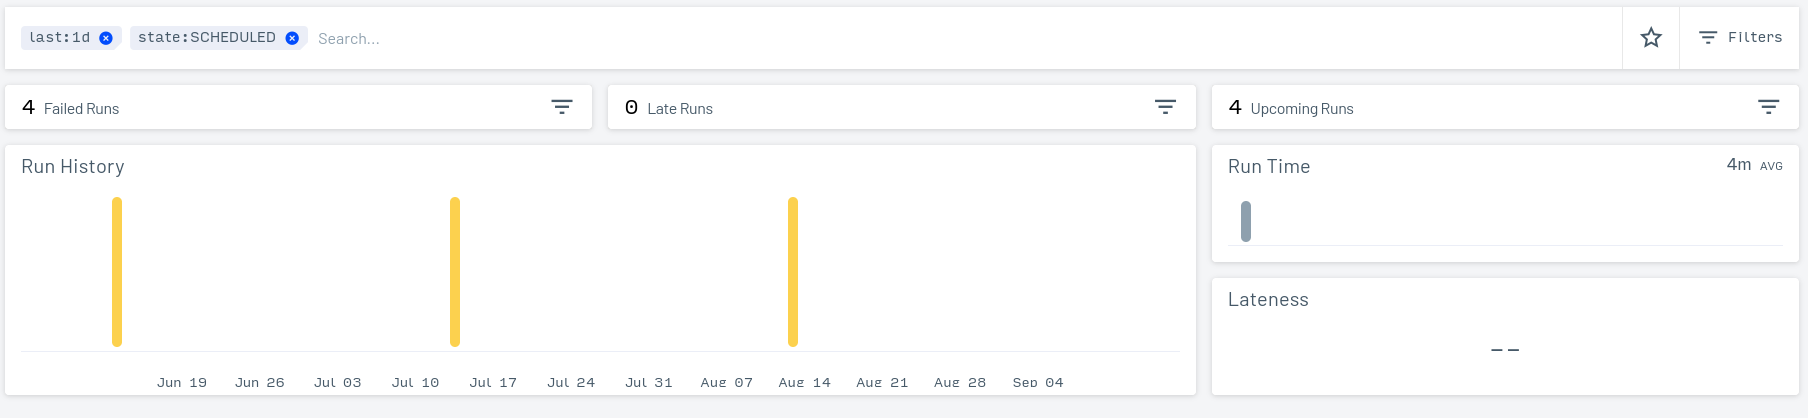

In [85]:
A5 = 4
print(f'Answer: {A5}')

Answer: 4


There is no option, for `4`

# Q6: Creating a work-queue

In order to run this flow, you will need an agent and a work queue (Run it by using the UI). Because we scheduled our flow or every month, it won't really get picked up by an agent. For this exercise, create a work-queue from the UI and view it using the CLI.

For all CLI commands with Prefect, you can use `--help` to get more information.

For example,

- `prefect --help`
- `prefect work-queue --help`


### What is the command to view the available work-queues?

In [86]:
! prefect work-queue ls

                                  Work Queues                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                                   ID ┃ Name               ┃ Concurrency Lim… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 64f7fa98-4e64-4a3d-beab-3fd8601d5cc4 │ Run model_training │ None             │
└──────────────────────────────────────┴────────────────────┴──────────────────┘
                          (**) denotes a paused queue                           


In [87]:
A6 = 'prefect work-queue ls'
print(f'Answer: {A6}')

Answer: prefect work-queue ls


# Full Code

```python
import os
import argparse
import pandas as pd
import pickle
import datetime
from dateutil.relativedelta import relativedelta


from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from prefect import flow, task, get_run_logger
from prefect.task_runners import SequentialTaskRunner


@task
def read_data(path):
    df = pd.read_parquet(path)
    return df

@task
def prepare_features(df, categorical, train=True):

    logger = get_run_logger()
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    mean_duration = df.duration.mean()
    if train:
        logger.info(f"The mean duration of training is {mean_duration}")
    else:
        logger.info(f"The mean duration of validation is {mean_duration}")

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    return df

@task
def train_model(df, categorical):
    logger = get_run_logger()

    train_dicts = df[categorical].to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts) 
    y_train = df.duration.values

    logger.info(f"The shape of X_train is {X_train.shape}")
    logger.info(f"The DictVectorizer has {len(dv.feature_names_)} features")

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    mse = mean_squared_error(y_train, y_pred, squared=False)
    logger.info(f"The MSE of training is: {mse}")
    return lr, dv

@task
def run_model(df, categorical, dv, lr):
    logger = get_run_logger()
    val_dicts = df[categorical].to_dict(orient='records')
    X_val = dv.transform(val_dicts) 
    y_pred = lr.predict(X_val)
    y_val = df.duration.values

    mse = mean_squared_error(y_val, y_pred, squared=False)
    logger.info(f"The MSE of validation is: {mse}")
    return

@task
def get_paths(date):
    logger = get_run_logger()

    if date == None:
        date = datetime.date.today()
    else:
        date = pd.to_datetime(date)

    date_train = date - relativedelta(months=2)
    date_val = date - relativedelta(months=1)

    date_train = date_train.strftime("%Y-%m")
    date_val = date_val.strftime("%Y-%m")
    
    # Complete val and train path
    train_path = 'data/fhv_tripdata_'+date_train+'.parquet'
    val_path = 'data/fhv_tripdata_'+date_val+'.parquet'  
    
    if not os.path.exists(train_path):
        url = f"https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_{date_train}.parquet"
        try:
            os.system(f"wget {url} -P \data")
        except:
            logger.warning(f"{url} not available")
            raise Exception('Train data not available')
    
    if not os.path.exists(val_path):
        url = f"https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_{date_val}.parquet"
        try:
            os.system(f"wget {url} -P \data")
        except:
            logger.warning(f"{url} not available")
            raise Exception('Val data not available')


        
    logger.info(f"Train path: {train_path}")
    logger.info(f"Val path: {val_path}")

    return train_path, val_path


@flow(task_runner=SequentialTaskRunner())
def main(date="2021-08-15"):

    train_path, val_path = get_paths(date).result()

    categorical = ['PUlocationID', 'DOlocationID']

    df_train = read_data(train_path)
    df_train_processed = prepare_features(df_train, categorical)

    df_val = read_data(val_path)
    df_val_processed = prepare_features(df_val, categorical, False)

    # train the model
    lr, dv = train_model(df_train_processed, categorical).result()
    run_model(df_val_processed, categorical, dv, lr)

    # Save models
    with open(f"models/model-{date}.bin", 'wb') as f_out:
        pickle.dump(lr, f_out)

    with open(f"models/dv-{date}.bin", 'wb') as f_out:
        pickle.dump(dv, f_out)


from prefect.deployments import DeploymentSpec
from prefect.orion.schemas.schedules import CronSchedule
from prefect.flow_runners import SubprocessFlowRunner

DeploymentSpec(
    flow=main,
    name='model_training',
    schedule=CronSchedule(cron='0 9 15 * *'),
    flow_runner=SubprocessFlowRunner(),
    tags=['first_model'],
)


# For Question 1/2/3
#if __name__ == '__main__':
#
#   parser = argparse.ArgumentParser()
#    parser.add_argument(
#        "--date",
#        default=None,
#        help="Date to catch the data to train and validate"
#    )
#    args = parser.parse_args()
#
#    main(args.date)
```